<a href="https://colab.research.google.com/github/mallibus/Unige-DL2019/blob/master/1_DeepCV_Colab_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1. Deep Computer Vision


In [0]:
from __future__ import print_function
import tensorflow as tf
import h5py, os, scipy.ndimage
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline


tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

Using TensorFlow backend.


TensorFlow version: 1.14.0
Eager execution: True



## Adding code snippet to load dataset/images from Google Drive folder (used later in 1.2)

*  Run this code block, it will ask for Google Drive authentication. After authenticating, copy URL into box, hit enter


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


Load one example of image from a Google Drive folder
* Click on arrow at left side of screen, then "Files". On the Directory Tree, navigate to "gdrive", which will contain your Drive folder as "My Drive"
* In My Drive, search for the folder containing this Lab-1 and find "dataset > small”
* right click on that corresponding folder, “copy path” 


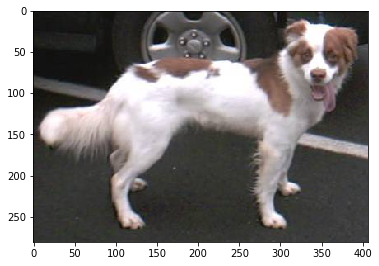

In [0]:
import os
# paste here path of Drive folder
base_dir = '/gdrive/My Drive/Labs/Lab-1/dataset/small'

# load an example image 
dog_dir = os.path.join(base_dir, 'test', 'dogs')
dog_img = plt.imread(os.path.join(dog_dir, 'dog.1500.jpg'))

# show image
plt.figure(figsize=(6,6))
plt.imshow(dog_img)
plt.show()

## 1.1 Convolutional Neural Network


<img src="http://mlclass.epizy.com/lab1_images_notebook/cnn.png" width="650px"><br>

Convolutional neural networks (ConvNets, CNN) are deep artificial neural networks that are used for many applications (e.g. image recognition, video analysis, nlp, time series, graph data and so on..).

A ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. <br>
Three main types of layers are used to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer; these layers are stacked to form a full ConvNet architecture.

**Feature Learning**
1. Convolution: Apply filters with learned weights to generate feature maps.<br>
2. Non Linearity: Often ReLU, sigmoid or tanh.<br>
3. Pooling: Downsampling operation on each feature map.<br>
 
**Classification**
1. Flatten: Convert the output of the Feature Learning part of the CNN into a 1D feature vector.<br>
2. Fully connected: Uses the features extracted from the previous layers for classifying input.<br>
3. Softmax: express output as probability of input data belonging to a particular class.<br>

### Note
If you cannot see the image in the previous block, click on the following link. <br>
http://mlclass.epizy.com/lab1_images_notebook/cnn.png

You will be redirected to an image. Come back and reload this page. You should be able to see the images on this page now.

### Define the CNN model
*  1. Import dataset
*  2. Build the model
*  3. Train the model 
*  4. Evaluate the model

### 1.1.1 Import CIFAR-10 dataset

In [0]:
(x_learn, y_learn),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_learn, x_test = x_learn / 255.0, x_test / 255.0 # normalize
x_train, x_val, y_train, y_val = train_test_split(x_learn, y_learn, test_size=0.3) # split train in train,val

print(x_train.shape, x_val.shape, x_test.shape)

170500096/170498071 [==============================] - 11s 0us/step
(35000, 32, 32, 3) (15000, 32, 32, 3) (10000, 32, 32, 3)


#### Plot some sample

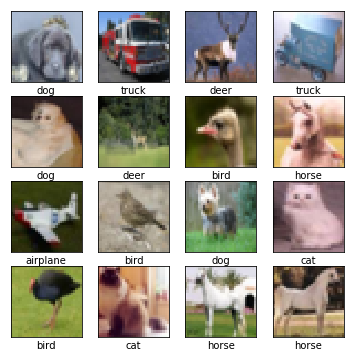

In [0]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

### 1.1.2 Build the model


#### Define the model parameters

In [0]:
num_classes = 10
n_filters = 32 

#### Define the model
Try to stack different layers (you could use this scheleton: (Conv(ReLU)+MaxPool+Dropout)*3 + Flatten + Droupout + Dense + Dense(softmax)).

In [0]:
def create_simplecnnmodel():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), input_shape=(32, 32, 3), activation=tf.nn.relu),     
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(filters=n_filters*2, kernel_size=(3,3), activation=tf.nn.relu), 
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=n_filters*4, kernel_size=(3,3), activation=tf.nn.relu), 
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])

In [0]:
cnn_model = create_simplecnnmodel()

#### Configures the model for training

In [0]:
# Optimizers https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
adad = tf.keras.optimizers.Adadelta(lr=1.0,rho=0.95,epsilon=None,decay=0.0)
adag = tf.keras.optimizers.Adagrad(lr=0.01,epsilon=None,decay=0.0)
adamax = tf.keras.optimizers.Adamax(lr=0.002,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0)
nadam = tf.keras.optimizers.Nadam(lr=0.002,beta_1=0.9,beta_2=0.999,epsilon=None,schedule_decay=0.004)
rms = tf.keras.optimizers.RMSprop(lr=0.001,rho=0.9,epsilon=None,decay=0.0)

# Losses https://keras.io/losses/
loss = ['sparse_categorical_crossentropy','binary_crossentropy','mean_squared_error','mean_absolute_error',
        'categorical_crossentropy','categorical_hinge']

# Metrics  https://www.tensorflow.org/api_docs/python/tf/metrics
metrics = ['accuracy','precision','recall']

#### Compile the model

In [0]:
cnn_model.compile(optimizer=rms, 
              loss=loss[0],
              metrics=[metrics[0]])

### 1.1.3 Train the model


In [0]:
epochs = 20
batch_size = 128
history = cnn_model.fit(x_train, y_train, batch_size=batch_size, 
                        validation_data =(x_val, y_val), epochs=epochs)

Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 6s 174us/sample - loss: 1.4749 - acc: 0.4655 - val_loss: 1.3727 - val_acc: 0.5051
Epoch 2/20
35000/35000 [==============================] - 6s 175us/sample - loss: 1.3791 - acc: 0.5024 - val_loss: 1.2438 - val_acc: 0.5479
Epoch 3/20
35000/35000 [==============================] - 6s 173us/sample - loss: 1.3186 - acc: 0.5280 - val_loss: 1.2120 - val_acc: 0.5649
Epoch 4/20
35000/35000 [==============================] - 6s 174us/sample - loss: 1.2647 - acc: 0.5487 - val_loss: 1.1305 - val_acc: 0.6011
Epoch 5/20
35000/35000 [==============================] - 6s 166us/sample - loss: 1.2152 - acc: 0.5649 - val_loss: 1.1558 - val_acc: 0.5843
Epoch 6/20
35000/35000 [==============================] - 6s 164us/sample - loss: 1.1808 - acc: 0.5772 - val_loss: 1.0777 - val_acc: 0.6139
Epoch 7/20
35000/35000 [==============================] - 6s 162us/sample - loss: 1.1427 - acc: 0.5923 - val_l

In [0]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

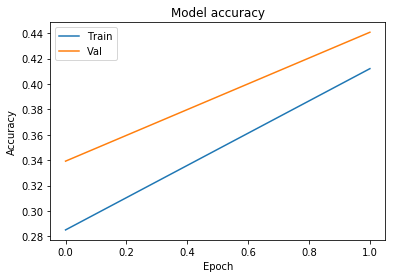

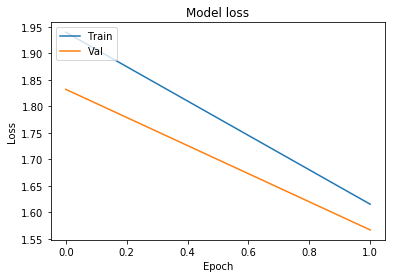

In [0]:
plot_history(history)

### 1.1.4 Evaluate the model

In [0]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

10000/10000 [==============================] - 3s 297us/sample - loss: 0.8238 - acc: 0.7165
Test accuracy: 0.716, Test loss: 0.824


#### Plot the confusion matrix

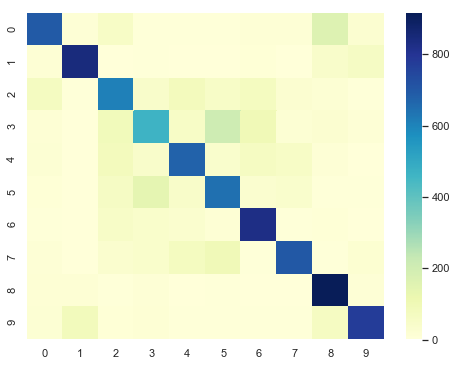

In [0]:
y_pred = np.argmax(cnn_model.predict(x_test),axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.set()

ax = sns.heatmap(cm, cmap="YlGnBu", annot=False)

#### Plot some missclassified sample

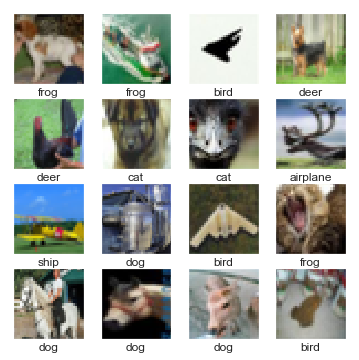

In [0]:
predictions = cnn_model.predict(x_test)

plt.figure(figsize=(6,6))
j = 0

for i in range(100):
    if(np.argmax(predictions[i]) != y_test[i]):
        plt.subplot(4,4,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_test[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[np.argmax(predictions[i])])
        j+=1
        if (j%16 == 0):
            break
plt.show()

#### Summary of the model (layers, input shape and parameters number)

In [0]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
__________

**Try to play with n_filters value.<br>
What happens? How the number of parameters of the network increase? How this value affects the accuracy?**

###Increasing this value I expect better performance (but it is also related by the number of data available and on the complexity of the problem)

## 1.2 Training a ConvNet from scratch on a small dataset

One common obstacle for using Deep Learning to solve problems is the amount of data needed to train a model. <br>
The requirement of large data arises because of the large number of parameters in the model that machines have to learn.<br>
There are different techniques that allow you to use deep architectures with a small amount of data:
    1. Data augmentation
    2. Pre-trained model
    3. Fine-tuning a pre-trained model

#### First of all evaluate how a simple model (as the model built in the first part) perform on a small dataset; then try the techniques listed above to see which works better.

#### Load dataset

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
#Load your dataset
import os
base_dir = '/gdrive/My Drive/Labs/Lab-1/dataset/small'#path where you store the dataset

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Binary classification problem: two class (cat vs dog)
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')


print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


#### Define the model parameters

In [0]:
n_filters = 32
num_classes = 1

#### Define the model

In [0]:
def create_cnnmodel():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), input_shape=(150, 150, 3), activation=tf.nn.relu),     
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.1),        
        tf.keras.layers.Conv2D(filters=n_filters*2, kernel_size=(3,3), activation=tf.nn.relu), 
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=n_filters*4, kernel_size=(3,3), activation=tf.nn.relu), 
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(filters=n_filters*4, kernel_size=(3,3), activation=tf.nn.relu), 
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

#### Create the model

In [0]:
cnn_model1 = create_cnnmodel()

#### Compile the model

In [0]:
cnn_model1.compile(optimizer=rms,
              loss=loss[1],
              metrics=[metrics[0]])

ImageDataGenerator class allows to generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches). Now we aren't doing augmentation, but we use this class only to normalize the data.

In [0]:
# Normalization
train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


#### Train the model using fit_generator()
fit_generator fits the model on data yielded batch-by-batch by a Python generator.

In [0]:
# 20 min on gpu
history = cnn_model1.fit_generator(
    train_generator,
    steps_per_epoch=1000, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/3
Instructions for updating:
Use tf.cast instead.
63/63 [==============================] - 51s 815ms/step - loss: 0.7991 - acc: 0.5210 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 2/3
63/63 [==============================] - 20s 322ms/step - loss: 0.6971 - acc: 0.5400 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 3/3
63/63 [==============================] - 20s 312ms/step - loss: 0.6972 - acc: 0.5345 - val_loss: 0.6898 - val_acc: 0.5000


In [0]:
plot_history(history)

#### Evaluate the model

In [0]:
test_loss, test_acc = cnn_model1.evaluate_generator(test_generator, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

32/32 [==============================] - 14s 443ms/step - loss: 0.6887 - acc: 0.5000
Test accuracy: 0.500, Test loss: 0.689


### 1.2.1 Data augmentation
Data augmentation is a technique to artificially create new training data from existing training data.<br>
Why more data could increase accuracy of a networks?

**Because with more data the network could better understand the distribution.**

In [0]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#### Plot some examples of augmented images

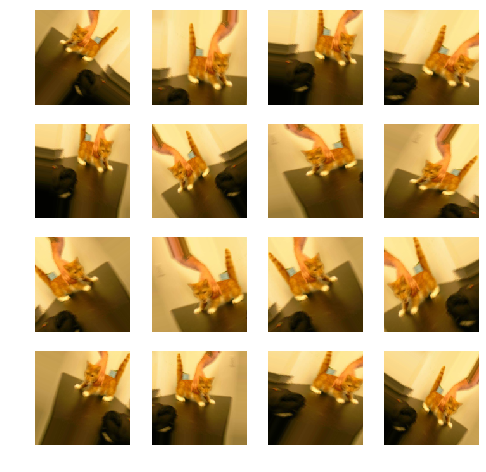

In [0]:
fnames = [os.path.join(train_cats_dir, fname) for
    fname in os.listdir(train_cats_dir)]

img_path = fnames[0]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0

plt.figure(figsize=(8,8))

for batch in datagen.flow(x, batch_size=1):
    plt.subplot(4,4,i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i % 16 == 0:
        break
        
plt.show()

#### Create the model

In [0]:
cnn_model_a = create_cnnmodel()

#### Compile the model

In [0]:
cnn_model_a.compile(optimizer=rms,
              loss=loss[1],#binary cross entropy
              metrics=[metrics[0]])

#### Create ImageDataGenerator for training and validation set

In [0]:
train_datagen_a = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen_a = ImageDataGenerator(rescale=1./255)

train_generator_a = train_datagen_a.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator_a = test_datagen_a.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

for data_batch, labels_batch in train_generator_a:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


#### Train the model using fit_generator()

In [0]:
# 50 min on gpu
history = cnn_model_a.fit_generator(
    train_generator_a,
    steps_per_epoch=1000,
    epochs=50,
    validation_data=validation_generator_a,
    validation_steps=50)

Epoch 1/3
63/63 [==============================] - 44s 701ms/step - loss: 0.7902 - acc: 0.4855 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 2/3
63/63 [==============================] - 41s 656ms/step - loss: 0.6973 - acc: 0.5065 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/3
63/63 [==============================] - 36s 571ms/step - loss: 0.6949 - acc: 0.5280 - val_loss: 0.6921 - val_acc: 0.5100


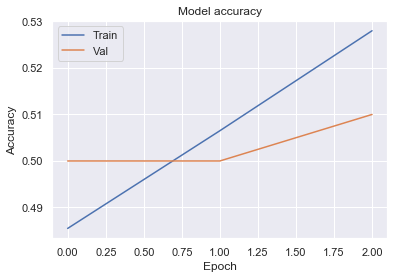

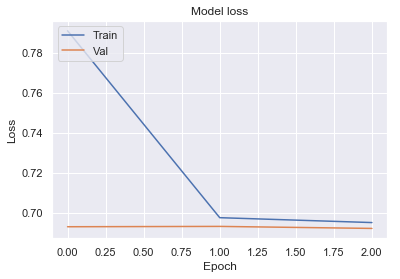

In [0]:
plot_history(history)

#### Evaluate the model

In [0]:
test_generator_a = test_datagen_a.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = cnn_model_a.evaluate_generator(test_generator_a, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 6s 127ms/step - loss: 0.6922 - acc: 0.5070
Test accuracy: 0.507, Test loss: 0.692


#### Save the model
It raise an error but it save the model

In [0]:
cnn_model_a.save('simple_cnn.h5')

RuntimeError: Unable to create link (name already exists)

### 1.2.2 Pre-trained ConvNet (Transfer Learning)
A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.<br>
If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task.<br>
So we use the representations learned by a previous network to extract interesting features from new samples; these features are then run through a new classifier, which is trained from scratch.<br>

<img src="http://mlclass.epizy.com/lab1_images_notebook/pre-trained.png" width="600px"><br>


#### Load the model
Here you can find a list of available pre-trained model https://github.com/keras-team/keras-applications/tree/master/keras_applications.

In [0]:
# Load VGG16
conv_base = tf.keras.applications.VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**Freeze the convolutional base**.<br>
Freezing a layer or set of layers means preventing their weights from being updated during training.

In [0]:
print('This is the number of trainable weights '
    'before freezing the conv base:', len(conv_base.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
    'after freezing the conv base:', len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


#### Create the model using a pre-trained model and a new classifier on the top

In [0]:
model = tf.keras.Sequential([
    conv_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model_a.summary()

#### Compile the model

In [0]:
model.compile(loss=loss[1],
    optimizer=rms,
    metrics=[metrics[0]])

#### Train the model without data augmentation

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/5
63/63 [==============================] - 30s 476ms/step - loss: 1.8581 - acc: 0.6995 - val_loss: 0.4417 - val_acc: 0.7760
Epoch 2/5
63/63 [==============================] - 24s 384ms/step - loss: 0.3792 - acc: 0.8365 - val_loss: 0.2868 - val_acc: 0.8760
Epoch 3/5
63/63 [==============================] - 24s 378ms/step - loss: 0.2953 - acc: 0.8735 - val_loss: 0.7839 - val_acc: 0.7460
Epoch 4/5
63/63 [==============================] - 24s 378ms/step - loss: 0.2810 - acc: 0.8870 - val_loss: 0.2869 - val_acc: 0.8870
Epoch 5/5
63/63 [==============================] - 24s 378ms/step - loss: 0.2006 - acc: 0.9235 - val_loss: 0.2490 - val_acc: 0.9000


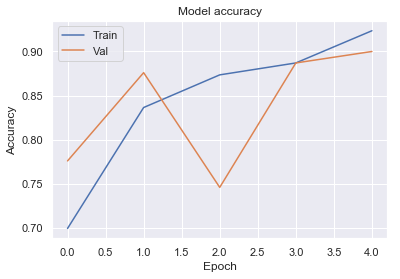

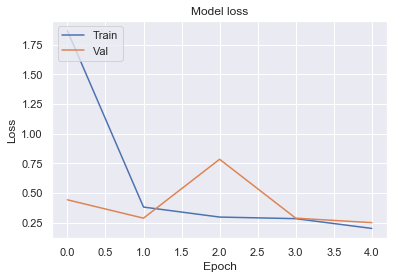

In [0]:
plot_history(history)

#### Evaluate the model

In [0]:
test_loss, test_acc = model.evaluate_generator(test_generator_a, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

50/50 [==============================] - 11s 228ms/step - loss: 0.2769 - acc: 0.8810
Test accuracy: 0.881, Test loss: 0.277


**What could you notice from the loss graph?**

Overfitting -> small data (not using data augmentation)

### 1.2.2 Pre-trained Convnet (Transfer Learning) with data augmentation
**This technique is so expensive that you should only attempt it if you
have access to a GPU—it’s absolutely intractable on CPU.<br> If you can’t run your
code on GPU, then the previous technique is the way to go.**

In [0]:
# Load VGG16
conv_base = tf.keras.applications.VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

conv_base.summary()

#### Freeze the convolutional base

In [0]:
conv_base.trainable = False

#### Build a model using a pre-trained convnet

In [0]:
model_a = tf.keras.Sequential([
    conv_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model_a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


#### Compile the model

In [0]:
model_a.compile(loss=loss[1],
    optimizer=rms,
    metrics=[metrics[0]])

In [0]:
train_datagen_a = ImageDataGenerator(rescale=1./255)

test_datagen_a = ImageDataGenerator(rescale=1./255)

train_generator_a = train_datagen_a.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator_a = test_datagen_a.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator_a = test_datagen_a.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Train the model

In [0]:
history = model_a.fit_generator(
    train_generator_a,
    steps_per_epoch=4,
    epochs=4,
    validation_data=validation_generator_a,
    validation_steps=50)

Epoch 1/4
63/63 [==============================] - 28s 446ms/step - loss: 1.2371 - acc: 0.7180 - val_loss: 0.4600 - val_acc: 0.7760
Epoch 2/4
63/63 [==============================] - 24s 379ms/step - loss: 0.3260 - acc: 0.8610 - val_loss: 0.2682 - val_acc: 0.8870
Epoch 3/4
63/63 [==============================] - 24s 380ms/step - loss: 0.2848 - acc: 0.8845 - val_loss: 0.2409 - val_acc: 0.9010
Epoch 4/4
63/63 [==============================] - 24s 382ms/step - loss: 0.2497 - acc: 0.9030 - val_loss: 0.3220 - val_acc: 0.8700


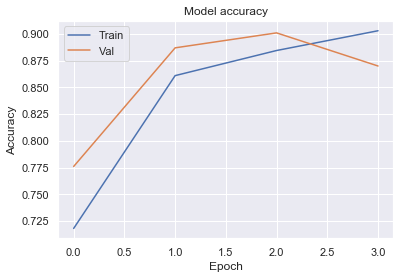

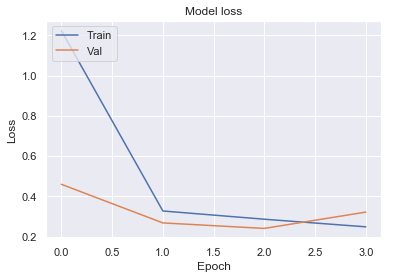

In [0]:
plot_history(history)

#### Evaluate the model

In [0]:
test_loss, test_acc = model_a.evaluate_generator(test_generator_a, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

32/32 [==============================] - 8s 250ms/step - loss: 0.3237 - acc: 0.8600
Test accuracy: 0.860, Test loss: 0.324


### 1.2.3 Fine-tuning a pre-trained model

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers
<br><br><br>
<img src="http://mlclass.epizy.com/lab1_images_notebook/fine_tuning.png" width="550px"><br>


In [0]:
# Load a pre trained model and freeze only the first layers
conv_base1 = tf.keras.applications.VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

conv_base1.summary()

conv_base1.trainable = True
set_trainable = False

# We fine-tune the last convolutional block of the VGG16 network (Conv block 5) and our own fully connected classifier.
for layer in conv_base1.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### Create the model

In [0]:
fmodel = tf.keras.Sequential([
    conv_base1,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

#### Compile the model

In [0]:
fmodel.compile(loss=loss[1],
    optimizer=rms,
    metrics=[metrics[0]])

#### Train the model

In [0]:
history = fmodel.fit_generator(
    train_generator_a,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator_a,
    validation_steps=50)

Epoch 1/30
 1/63 [..............................] - ETA: 8:59 - loss: 0.7406 - acc: 0.4062

ResourceExhaustedError: OOM when allocating tensor with shape[32,64,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block1_conv2_11/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node ConstantFoldingCtrl/loss_14/dense_29_loss/broadcast_weights/assert_broadcastable/AssertGuard/Switch_0/_23}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:StatefulPartitionedCall]

In [0]:
plot_history(history)

#### Evaluate the model

In [0]:
test_loss, test_acc = fmodel.evaluate_generator(test_generator_a, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

## 1.3 Visualizing what convnets learn
    1. Visualizing intermediate convnet outputs (intermediate activations)
    2. Visualizing heatmaps of class activation in an image (CAM)

### 1.3.1 Visualizing intermediate convnet outputs (intermediate activations)
Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function).<br>
In other words we want to visualize the activations of the network during the forward pass.<br>
This gives a view into how an input is decomposed into the different filters learned by the network.


#### Load the model saved before

In [0]:
model = tf.keras.models.load_model('simple_cnn.h5')

# Extracts the outputs of the top eight layers
layer_outputs = [layer.output for layer in model.layers[:8]] 

# Creates a model that will return these outputs, given the model input
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs) 

In [0]:
def get_image(path,num):
    ''' Given a path and a number i, this function return the i-th image of the path '''
    fnames = [os.path.join(path, fname) for
        fname in os.listdir(path)]
    img_path = fnames[num]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)

    img_tensor = np.expand_dims(x, axis=0)
    img_tensor /= 255.

    return img_tensor

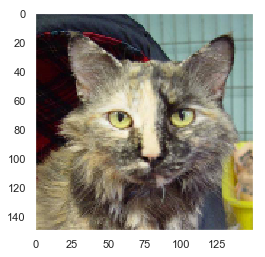

In [0]:
im = get_image(train_cats_dir,2)

plt.rcParams["axes.grid"] = False
plt.imshow(im[0])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
__________

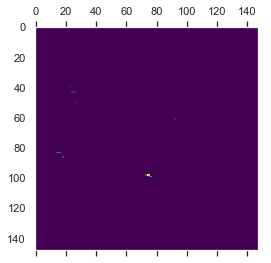

In [0]:
# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(im)

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
plt.show()

#### Visualizing every channel in every intermediate activation

C:\Users\canta\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


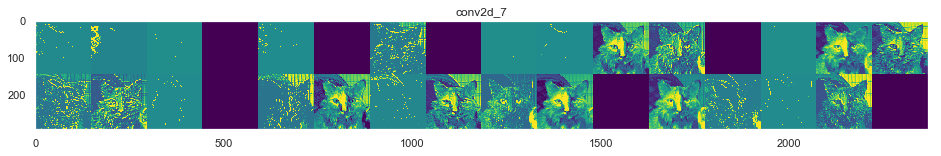

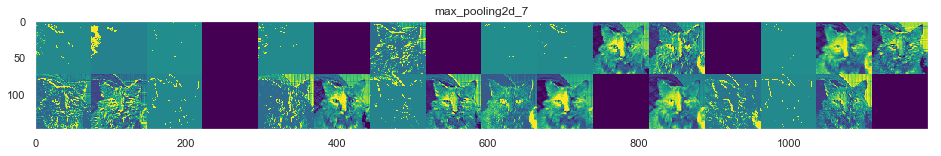

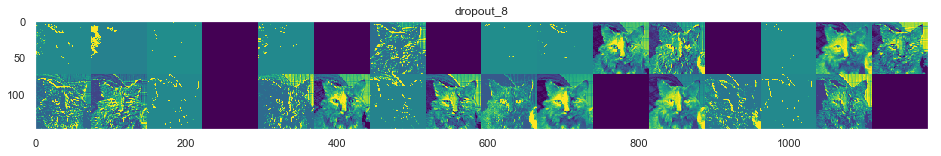

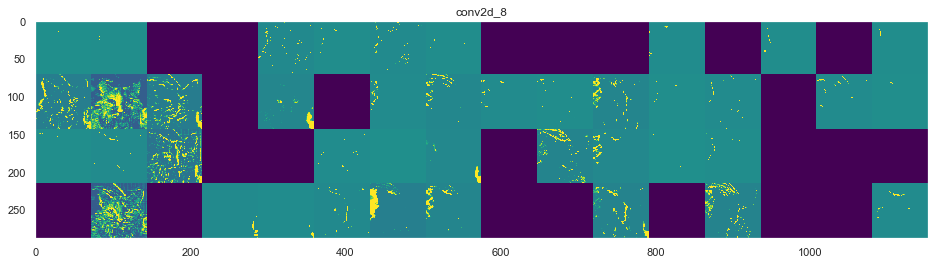

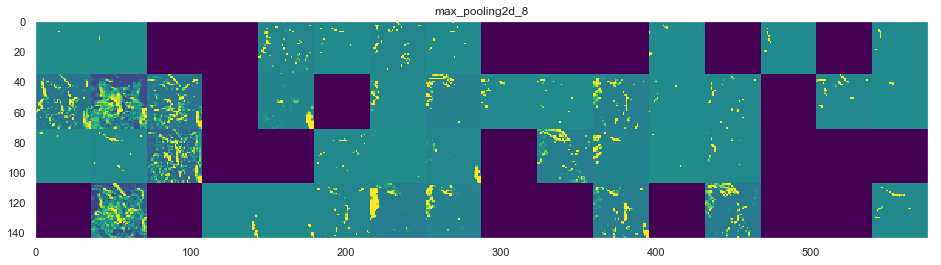

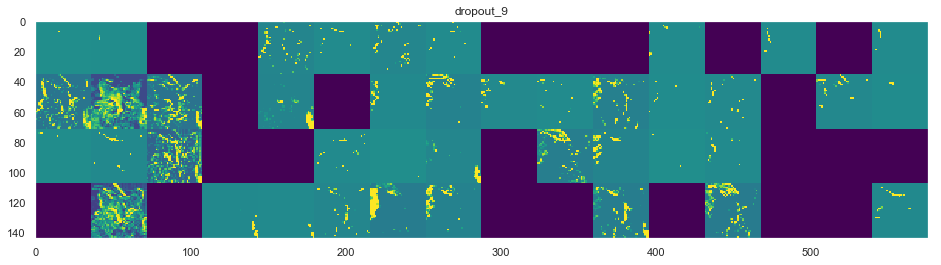

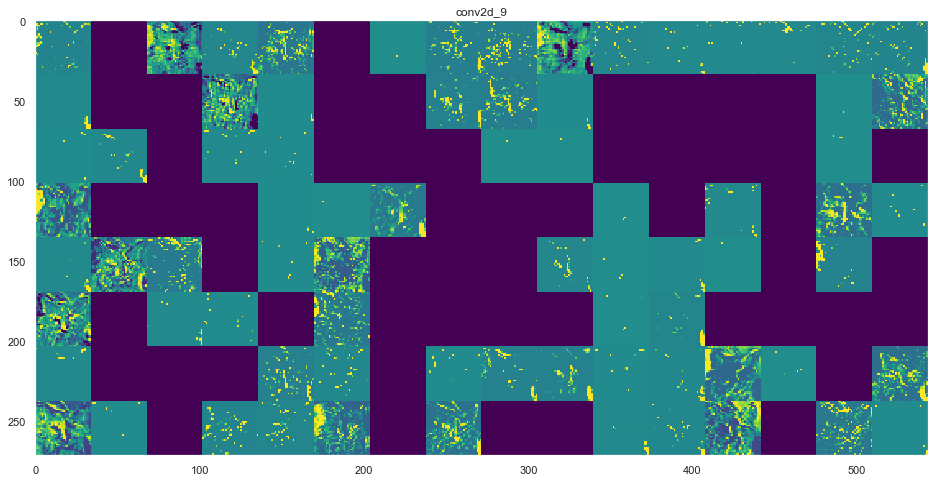

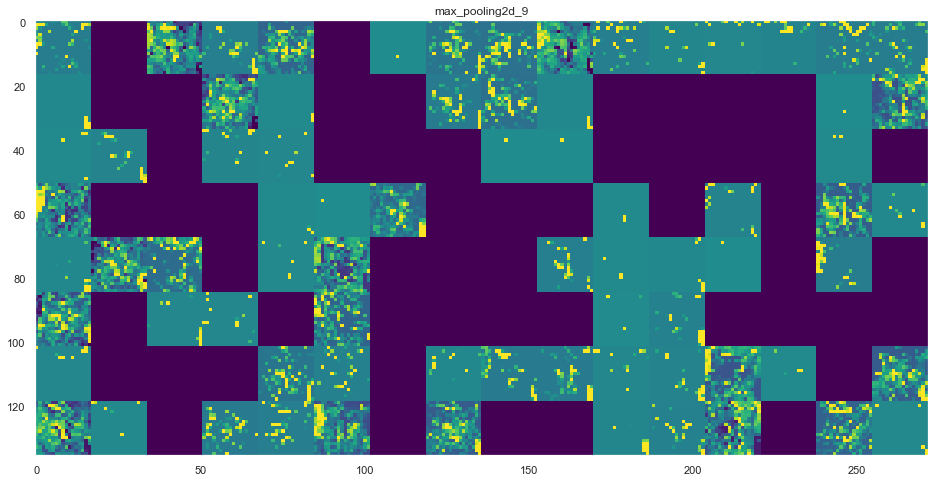

In [0]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Note that there are several filters that are not activated and are left blank. In the first stage, the activations retain almost all of the information present in the initial picture; in fact, for ReLU networks, the activations usually start out looking relatively dense, but as the training progresses the activations usually become more sparse and localized.<br>
Going deeper in the layers, the activations become increasingly abstract and less visually interpretable.

### 1.3.2 Class Activation Mapping
What the CNN is looking?<br>
This technique generates class activation maps using the global average pooling (GAP); a class activation map for a particular category indicates the discriminative image regions used by the CNN to identify that category.<br>
The procedure for generating these maps is illustrated as follows:
<img src="http://mlclass.epizy.com/lab1_images_notebook/cam.jpg" width="600px"><br>
Class activation maps could be used to intepret the prediction decision made by the CNN.<br>
(Original paper: http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)


#### Load ResNet50 pre-trained model with imagenet weights

In [0]:
resnet = tf.keras.applications.ResNet50(weights='imagenet',
    include_top=True,
    input_shape=(224, 224, 3))

resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

#### Create another model $m_{1}$, that take the same input of ResNet50 but has as output the last activation layer of ResNet50 ( activation_48 )

In [0]:
activation_layer = resnet.get_layer('activation_48')

m1 = tf.keras.Model(inputs = resnet.input, outputs = activation_layer.output)

#### Get the feaure map weights

In [0]:
final_dense = resnet.get_layer('fc1000')
W = final_dense.get_weights()[0]

#### Load an image (the shape has to coincide to the shape that the model take as input) 

In [0]:
path_picture = "C:\\Users\\canta\\Pictures\\Screenshots\\1.png"
img = image.load_img(path_picture,target_size =(224,224))

# pre-process input
x = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(img,0))

####  Use the output of the model m1 (7x7x2048) and multiply by the weigths (2048x1) for the "relevant" class (higher score)

In [0]:
fmaps = m1.predict(x)[0] # 7 x 7 x 2048

# get predicted class by ResNet50
probs = resnet.predict(x)

classnames = tf.keras.applications.resnet50.decode_predictions(probs)[0]
print(classnames)

classname = classnames[0][1]
pred = np.argmax(probs[0])

#get the 2048 weights for the relevant class
w = W[:,pred] # 2048

# make the dot product between fmaps and w
cam = fmaps.dot(w)

[('n04200800', 'shoe_shop', 0.078628145), ('n03032252', 'cinema', 0.07770013), ('n04296562', 'stage', 0.04181646), ('n02871525', 'bookshop', 0.036783695), ('n06794110', 'street_sign', 0.03577635)]


#### Upsample the output in order to see the discriminative image regions used by the CNN to identify that category

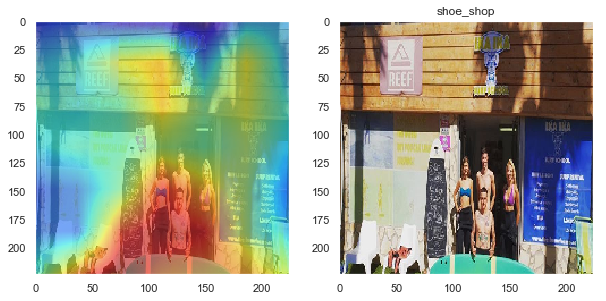

In [0]:
# upsample to 224 (32x7)
cam = scipy.ndimage.zoom(cam, (32,32), order=1)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(img, alpha=0.8)
plt.imshow(cam, cmap='jet', alpha=0.5)

plt.subplot(1,2,2)
plt.imshow(img)
plt.title(classname)
plt.show()

#### Here you can find a list of pointers to datasets you can play with:
https://ai.google/tools/datasets/ <br>
https://www.kaggle.com/alxmamaev/flowers-recognition <br>
https://www.kaggle.com/kmader/food41/version/5#images.zip <br>
https://www.kaggle.com/c/recognizing-faces-in-the-wild/data <br>
https://www.kaggle.com/moltean/fruits